In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

Modified timestamps for file u00001s00001_hw00002.svc:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32




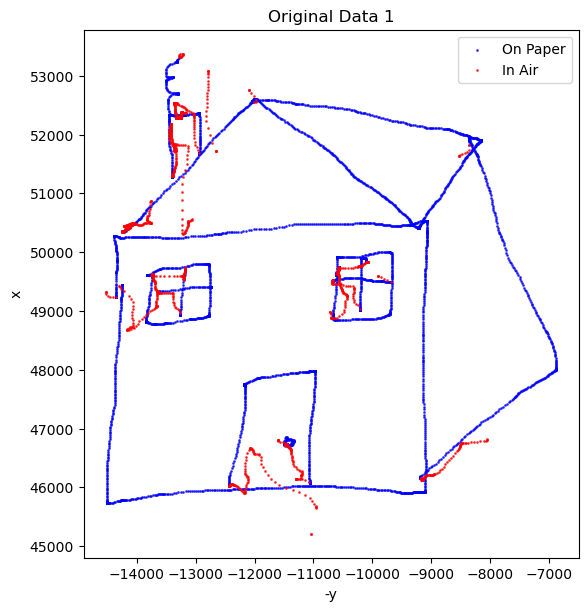

Number of processed files: 1
Average number of data points: 5553


In [2]:
# Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames  # Return the filenames

directory = 'Task2'  # Directory where the .svc files are stored
num_files_to_use = 1
data_frames, processed_data, scalers, avg_data_points, input_filenames = upload_and_process_files(directory, num_files_to_use)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

In [3]:
# Cell 3
# Process each DataFrame instead of just the first one
for df_idx in range(len(data_frames)):
    df = data_frames[df_idx]  # Using each DataFrame in the list

    # Convert the 'timestamp' column to numeric for calculations (if not already done)
    df['timestamp'] = pd.to_numeric(df['timestamp'])

    # Sort the DataFrame by timestamp (should already be sorted in the function)
    df.sort_values('timestamp', inplace=True)

    # Calculate the differences between consecutive timestamps (optional for gap finding)
    df['time_diff'] = df['timestamp'].diff()

    # Identify the indices where the time difference is greater than 30,000 milliseconds
    gap_indices = df.index[df['time_diff'] > 30000].tolist()

    # Create an empty list to hold the new rows
    new_rows = []

    # Fill in the gaps with 70 milliseconds intervals
    for idx in gap_indices:
        # Check if the next index is valid
        if idx + 1 < len(df):
            # Get the current and next timestamps
            current_timestamp = df.at[idx, 'timestamp']
            next_timestamp = df.at[idx + 1, 'timestamp']

            # Calculate how many entries we need to fill in
            num_fill_entries = (next_timestamp - current_timestamp) // 20000

            # Generate the timestamps to fill the gap
            for i in range(1, num_fill_entries + 1):
                new_timestamp = current_timestamp + i * 70

                # Create a new row to fill in with NaN for x and y
                new_row = {
                    'x': np.nan,  # Set x to NaN
                    'y': np.nan,  # Set y to NaN
                    'timestamp': new_timestamp,
                    'pen_status': 0,        # You can set this to your desired value
                    'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                    'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                    'pressure': df.at[idx, 'pressure']  # Use the current pressure value
                }

                # Append the new row to the list of new rows
                new_rows.append(new_row)

    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the original DataFrame with the new rows DataFrame
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Sort the DataFrame by timestamp to maintain order
    df.sort_values('timestamp', inplace=True)

    # Reset index after sorting
    df.reset_index(drop=True, inplace=True)

    # Interpolate NaN values in 'x' and 'y' columns based on nearest neighbors
    # Check for NaN entries before interpolation
    if df[['x', 'y']].isnull().any().any():
        df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

    # Drop the 'time_diff' column after processing
    df.drop(columns=['time_diff'], inplace=True)

    # Update the processed data
    data_frames[df_idx] = df

# Update processed data for all DataFrames
processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                  for df, scaler in zip(data_frames, scalers)]
avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

In [4]:

# Cell 4
processed_dataframes = []

for input_filename, df in zip(input_filenames, data_frames):
    # Convert all numeric columns to integers
    df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']] = df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']].astype(int)
    
    # Append the processed DataFrame to the list
    processed_dataframes.append(df)

    print(f"Processed DataFrame for: {input_filename}")



Processed DataFrame for: u00001s00001_hw00002.svc


Modified timestamps for DataFrame 1:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32




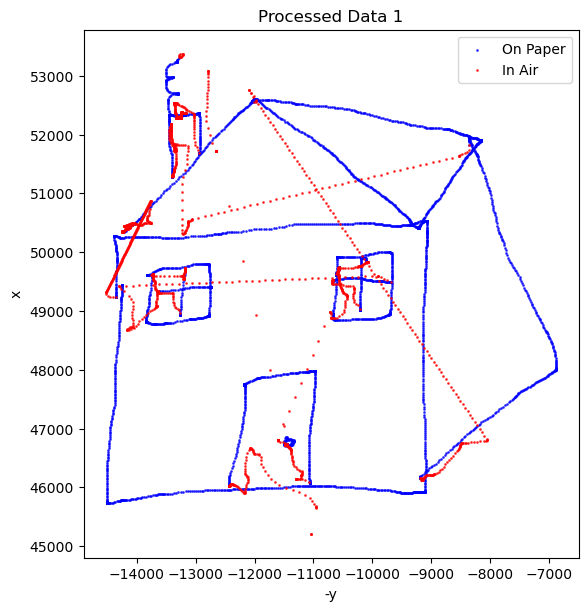

Number of processed files: 1
Average number of data points: 5971


In [5]:
# Cell 5 (modified)
def process_dataframes(dataframes, num_files_to_use=None):
    if num_files_to_use:
        dataframes = dataframes[:num_files_to_use]

    data_frames = []
    scalers = []

    num_files = len(dataframes)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, df in enumerate(dataframes):
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Processed Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for DataFrame {i + 1}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, [f"DataFrame_{i+1}" for i in range(len(dataframes))]

# Use the processed_dataframes directly
data_frames, processed_data, scalers, avg_data_points, original_filenames = process_dataframes(processed_dataframes, num_files_to_use)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

In [9]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, **kwargs):  # Added **kwargs to handle extra arguments
        super(VAE, self).__init__(**kwargs)  # Pass kwargs to the parent class
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        # Handle any unexpected keys like 'trainable' by removing them
        config.pop('trainable', None)
        config.pop('dtype', None)  # Also remove 'dtype' if included
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        # Add the VAE-specific arguments
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 128
beta = 0.0001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [10]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        
        # Retain original columns for pressure, azimuth, and altitude
        original_data = data_frames[i % num_input_files]  # Use original unprocessed data
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        # Determine the number of points for this augmented dataset
        # num_points = int(avg_data_points * (1 + np.random.uniform(-length_variability, length_variability)))
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        # Encode and reparameterize
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()
        
        # # Adjust number of points
        # if num_points > augmented_data.shape[0]:
        #     extra_indices = np.random.choice(augmented_data.shape[0], num_points - augmented_data.shape[0])
        #     augmented_data = np.vstack((augmented_data, augmented_data[extra_indices]))
        # elif num_points < augmented_data.shape[0]:
        #     keep_indices = np.random.choice(augmented_data.shape[0], num_points, replace=False)
        #     augmented_data = augmented_data[keep_indices]

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        # Append the pressure, azimuth, and altitude columns from the original data
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/100: 100%|██████████| 12/12 [00:12<00:00,  1.01s/batch, Generator Loss=0.00096, Reconstruction Loss=0.000568, KL Loss=3.91] 


Epoch 1: Generator Loss = 0.000929, Reconstruction Loss = 0.000534, KL Divergence Loss = 3.945130
NRMSE = 0.328527


Epoch 2/100: 100%|██████████| 12/12 [00:00<00:00, 38.56batch/s, Generator Loss=0.000864, Reconstruction Loss=0.000469, KL Loss=3.95]


Epoch 2: Generator Loss = 0.000930, Reconstruction Loss = 0.000536, KL Divergence Loss = 3.944268
NRMSE = 0.327661


Epoch 3/100: 100%|██████████| 12/12 [00:00<00:00, 20.81batch/s, Generator Loss=0.000934, Reconstruction Loss=0.000529, KL Loss=4.06]


Epoch 3: Generator Loss = 0.000953, Reconstruction Loss = 0.000559, KL Divergence Loss = 3.939376
NRMSE = 0.327835


Epoch 4/100: 100%|██████████| 12/12 [00:00<00:00, 39.54batch/s, Generator Loss=0.000937, Reconstruction Loss=0.000544, KL Loss=3.93]


Epoch 4: Generator Loss = 0.000914, Reconstruction Loss = 0.000521, KL Divergence Loss = 3.922021
NRMSE = 0.327537


Epoch 5/100: 100%|██████████| 12/12 [00:00<00:00, 39.93batch/s, Generator Loss=0.000914, Reconstruction Loss=0.000522, KL Loss=3.92]


Epoch 5: Generator Loss = 0.000900, Reconstruction Loss = 0.000509, KL Divergence Loss = 3.915416
NRMSE = 0.326581


Epoch 6/100: 100%|██████████| 12/12 [00:00<00:00, 34.94batch/s, Generator Loss=0.00101, Reconstruction Loss=0.000616, KL Loss=3.92] 


Epoch 6: Generator Loss = 0.000919, Reconstruction Loss = 0.000528, KL Divergence Loss = 3.905390
NRMSE = 0.328486


Epoch 7/100: 100%|██████████| 12/12 [00:00<00:00, 35.37batch/s, Generator Loss=0.000889, Reconstruction Loss=0.000503, KL Loss=3.86]


Epoch 7: Generator Loss = 0.000873, Reconstruction Loss = 0.000483, KL Divergence Loss = 3.896499
NRMSE = 0.327157


Epoch 8/100: 100%|██████████| 12/12 [00:00<00:00, 17.85batch/s, Generator Loss=0.000795, Reconstruction Loss=0.000411, KL Loss=3.84]


Epoch 8: Generator Loss = 0.000885, Reconstruction Loss = 0.000497, KL Divergence Loss = 3.884752
NRMSE = 0.328726


Epoch 9/100: 100%|██████████| 12/12 [00:00<00:00, 21.04batch/s, Generator Loss=0.000835, Reconstruction Loss=0.000448, KL Loss=3.87]


Epoch 9: Generator Loss = 0.000858, Reconstruction Loss = 0.000470, KL Divergence Loss = 3.876658
NRMSE = 0.328093


Epoch 10/100: 100%|██████████| 12/12 [00:00<00:00, 32.00batch/s, Generator Loss=0.000864, Reconstruction Loss=0.00048, KL Loss=3.84] 


Epoch 10: Generator Loss = 0.000857, Reconstruction Loss = 0.000470, KL Divergence Loss = 3.869990
NRMSE = 0.327751


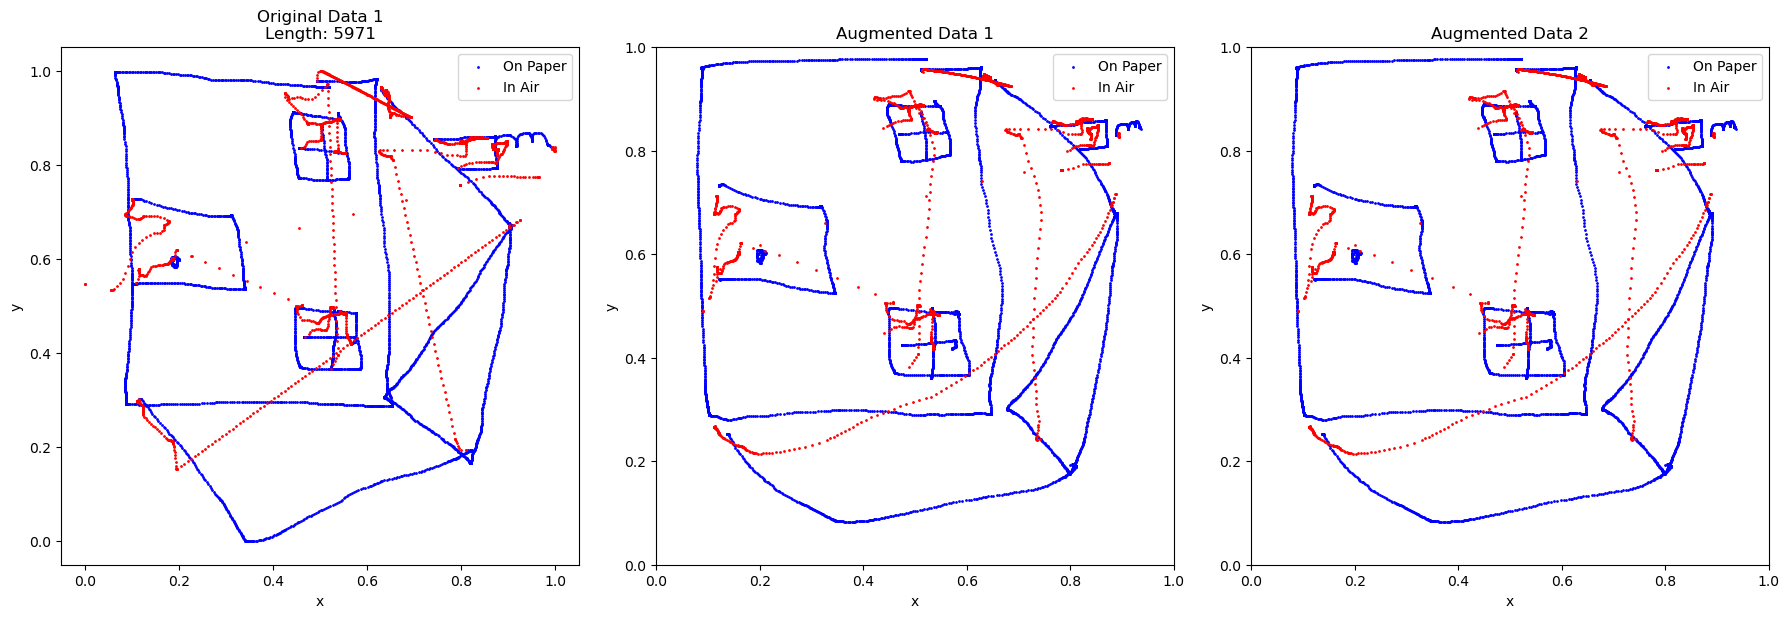

Epoch 11/100: 100%|██████████| 12/12 [00:00<00:00, 36.97batch/s, Generator Loss=0.000819, Reconstruction Loss=0.000437, KL Loss=3.82]


Epoch 11: Generator Loss = 0.000846, Reconstruction Loss = 0.000460, KL Divergence Loss = 3.858781
NRMSE = 0.327578


Epoch 12/100: 100%|██████████| 12/12 [00:00<00:00, 40.25batch/s, Generator Loss=0.000804, Reconstruction Loss=0.000414, KL Loss=3.9] 


Epoch 12: Generator Loss = 0.000839, Reconstruction Loss = 0.000454, KL Divergence Loss = 3.856065
NRMSE = 0.328766


Epoch 13/100: 100%|██████████| 12/12 [00:00<00:00, 40.98batch/s, Generator Loss=0.000876, Reconstruction Loss=0.000492, KL Loss=3.84]


Epoch 13: Generator Loss = 0.000837, Reconstruction Loss = 0.000451, KL Divergence Loss = 3.851306
NRMSE = 0.328552


Epoch 14/100: 100%|██████████| 12/12 [00:00<00:00, 39.50batch/s, Generator Loss=0.000886, Reconstruction Loss=0.000505, KL Loss=3.81]


Epoch 14: Generator Loss = 0.000808, Reconstruction Loss = 0.000424, KL Divergence Loss = 3.839911
NRMSE = 0.327820


Epoch 15/100: 100%|██████████| 12/12 [00:00<00:00, 16.19batch/s, Generator Loss=0.000791, Reconstruction Loss=0.000409, KL Loss=3.83]


Epoch 15: Generator Loss = 0.000793, Reconstruction Loss = 0.000410, KL Divergence Loss = 3.837655
NRMSE = 0.327858


Epoch 16/100: 100%|██████████| 12/12 [00:00<00:00, 31.98batch/s, Generator Loss=0.000762, Reconstruction Loss=0.000378, KL Loss=3.85]


Epoch 16: Generator Loss = 0.000803, Reconstruction Loss = 0.000420, KL Divergence Loss = 3.830620
NRMSE = 0.327814


Epoch 17/100: 100%|██████████| 12/12 [00:00<00:00, 37.96batch/s, Generator Loss=0.000801, Reconstruction Loss=0.00042, KL Loss=3.81] 


Epoch 17: Generator Loss = 0.000800, Reconstruction Loss = 0.000418, KL Divergence Loss = 3.823963
NRMSE = 0.329824


Epoch 18/100: 100%|██████████| 12/12 [00:00<00:00, 40.59batch/s, Generator Loss=0.00082, Reconstruction Loss=0.000444, KL Loss=3.75] 


Epoch 18: Generator Loss = 0.000802, Reconstruction Loss = 0.000420, KL Divergence Loss = 3.813449
NRMSE = 0.327851


Epoch 19/100: 100%|██████████| 12/12 [00:00<00:00, 20.68batch/s, Generator Loss=0.000809, Reconstruction Loss=0.000424, KL Loss=3.85]


Epoch 19: Generator Loss = 0.000797, Reconstruction Loss = 0.000416, KL Divergence Loss = 3.810849
NRMSE = 0.328263


Epoch 20/100: 100%|██████████| 12/12 [00:00<00:00, 33.71batch/s, Generator Loss=0.000878, Reconstruction Loss=0.000499, KL Loss=3.8] 


Epoch 20: Generator Loss = 0.000795, Reconstruction Loss = 0.000415, KL Divergence Loss = 3.798094
NRMSE = 0.327485


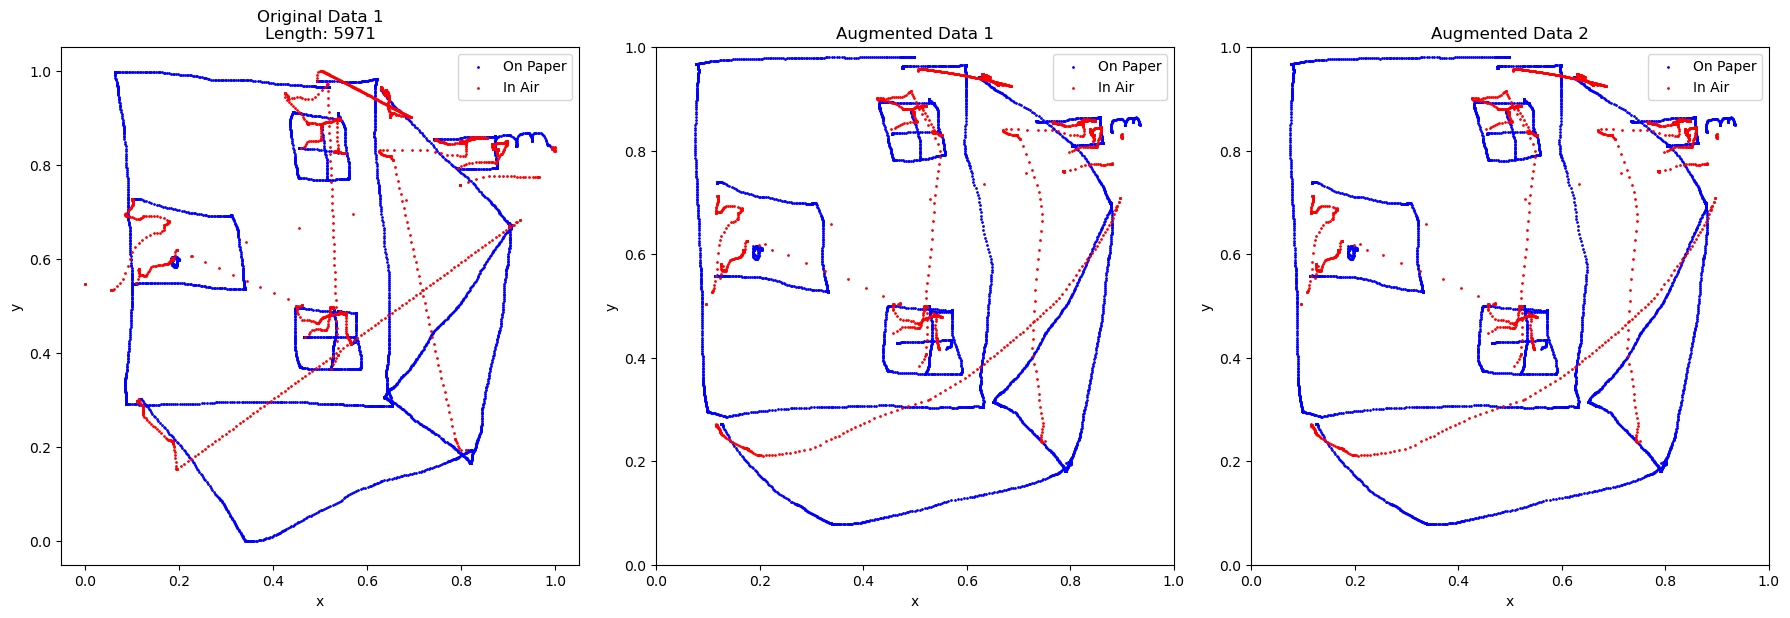

Epoch 21/100: 100%|██████████| 12/12 [00:00<00:00, 20.62batch/s, Generator Loss=0.000827, Reconstruction Loss=0.000446, KL Loss=3.81]


Epoch 21: Generator Loss = 0.000777, Reconstruction Loss = 0.000398, KL Divergence Loss = 3.791742
NRMSE = 0.329322


Epoch 22/100: 100%|██████████| 12/12 [00:00<00:00, 36.75batch/s, Generator Loss=0.000731, Reconstruction Loss=0.000347, KL Loss=3.83]


Epoch 22: Generator Loss = 0.000780, Reconstruction Loss = 0.000402, KL Divergence Loss = 3.782030
NRMSE = 0.328143


Epoch 23/100: 100%|██████████| 12/12 [00:00<00:00, 41.74batch/s, Generator Loss=0.000814, Reconstruction Loss=0.000437, KL Loss=3.77]


Epoch 23: Generator Loss = 0.000766, Reconstruction Loss = 0.000389, KL Divergence Loss = 3.771399
NRMSE = 0.330731


Epoch 24/100: 100%|██████████| 12/12 [00:00<00:00, 29.85batch/s, Generator Loss=0.000757, Reconstruction Loss=0.000382, KL Loss=3.75]


Epoch 24: Generator Loss = 0.000775, Reconstruction Loss = 0.000399, KL Divergence Loss = 3.762637
NRMSE = 0.328756


Epoch 25/100: 100%|██████████| 12/12 [00:00<00:00, 16.63batch/s, Generator Loss=0.000693, Reconstruction Loss=0.00033, KL Loss=3.63] 


Epoch 25: Generator Loss = 0.000752, Reconstruction Loss = 0.000377, KL Divergence Loss = 3.749283
NRMSE = 0.328479


Epoch 26/100: 100%|██████████| 12/12 [00:00<00:00, 41.48batch/s, Generator Loss=0.000801, Reconstruction Loss=0.000426, KL Loss=3.75]


Epoch 26: Generator Loss = 0.000764, Reconstruction Loss = 0.000390, KL Divergence Loss = 3.740850
NRMSE = 0.328837


Epoch 27/100: 100%|██████████| 12/12 [00:00<00:00, 36.29batch/s, Generator Loss=0.000757, Reconstruction Loss=0.00039, KL Loss=3.67] 


Epoch 27: Generator Loss = 0.000757, Reconstruction Loss = 0.000384, KL Divergence Loss = 3.727414
NRMSE = 0.328558


Epoch 28/100: 100%|██████████| 12/12 [00:00<00:00, 41.18batch/s, Generator Loss=0.000701, Reconstruction Loss=0.000333, KL Loss=3.68]


Epoch 28: Generator Loss = 0.000708, Reconstruction Loss = 0.000336, KL Divergence Loss = 3.720179
NRMSE = 0.330363


Epoch 29/100: 100%|██████████| 12/12 [00:00<00:00, 40.20batch/s, Generator Loss=0.000699, Reconstruction Loss=0.000327, KL Loss=3.72]


Epoch 29: Generator Loss = 0.000716, Reconstruction Loss = 0.000344, KL Divergence Loss = 3.714361
NRMSE = 0.328554


Epoch 30/100: 100%|██████████| 12/12 [00:00<00:00, 14.11batch/s, Generator Loss=0.000689, Reconstruction Loss=0.000326, KL Loss=3.63]


Epoch 30: Generator Loss = 0.000697, Reconstruction Loss = 0.000327, KL Divergence Loss = 3.704393
NRMSE = 0.331015


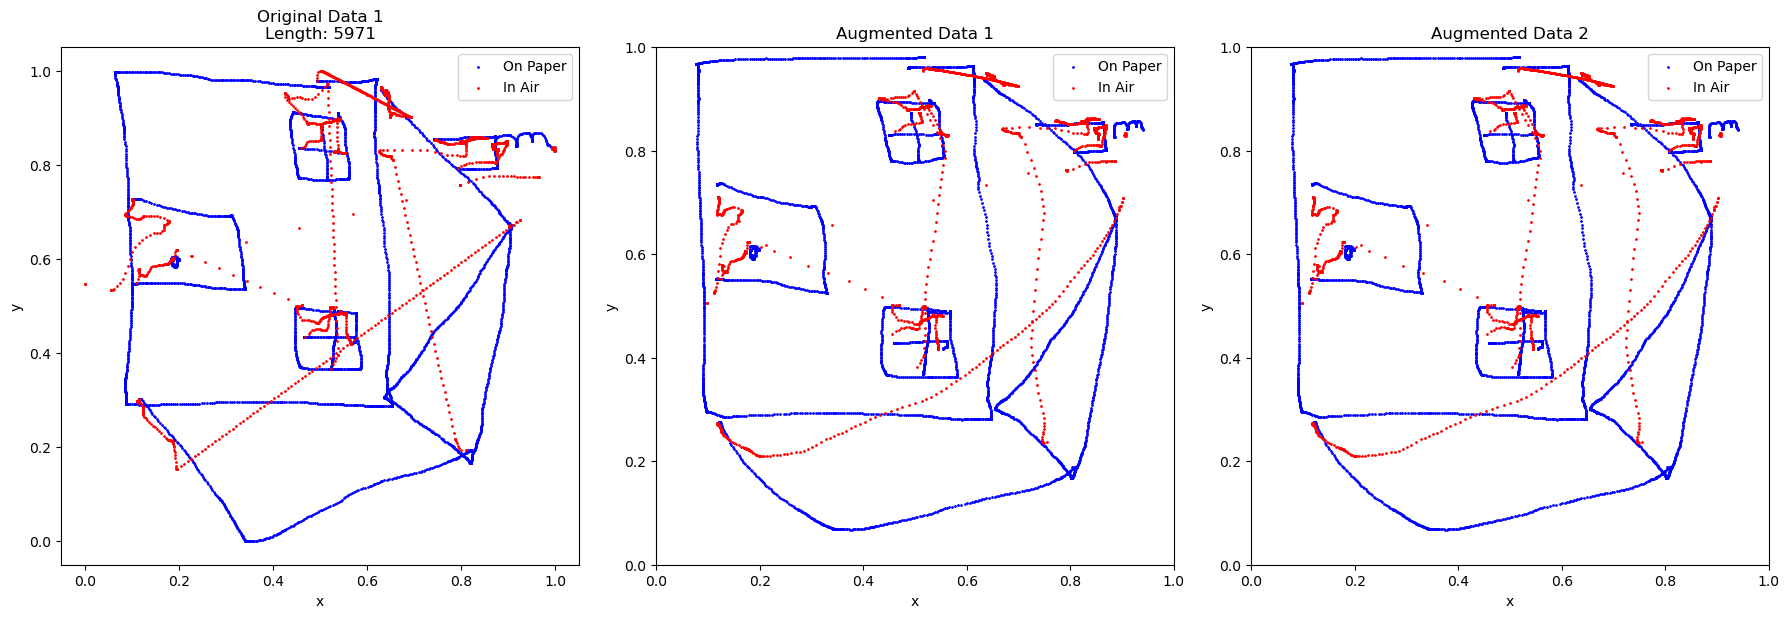

Epoch 31/100: 100%|██████████| 12/12 [00:00<00:00, 15.73batch/s, Generator Loss=0.00075, Reconstruction Loss=0.000381, KL Loss=3.68] 


Epoch 31: Generator Loss = 0.000704, Reconstruction Loss = 0.000334, KL Divergence Loss = 3.698831
NRMSE = 0.329451


Epoch 32/100: 100%|██████████| 12/12 [00:00<00:00, 41.94batch/s, Generator Loss=0.000706, Reconstruction Loss=0.000341, KL Loss=3.64]


Epoch 32: Generator Loss = 0.000700, Reconstruction Loss = 0.000331, KL Divergence Loss = 3.691108
NRMSE = 0.329160


Epoch 33/100: 100%|██████████| 12/12 [00:00<00:00, 41.47batch/s, Generator Loss=0.000719, Reconstruction Loss=0.000359, KL Loss=3.6] 


Epoch 33: Generator Loss = 0.000693, Reconstruction Loss = 0.000324, KL Divergence Loss = 3.685530
NRMSE = 0.329692


Epoch 34/100: 100%|██████████| 12/12 [00:00<00:00, 16.74batch/s, Generator Loss=0.000699, Reconstruction Loss=0.000328, KL Loss=3.71]


Epoch 34: Generator Loss = 0.000711, Reconstruction Loss = 0.000343, KL Divergence Loss = 3.683134
NRMSE = 0.330895


Epoch 35/100: 100%|██████████| 12/12 [00:00<00:00, 17.74batch/s, Generator Loss=0.000708, Reconstruction Loss=0.000344, KL Loss=3.64]


Epoch 35: Generator Loss = 0.000694, Reconstruction Loss = 0.000327, KL Divergence Loss = 3.673652
NRMSE = 0.329682


Epoch 36/100: 100%|██████████| 12/12 [00:00<00:00, 20.01batch/s, Generator Loss=0.000716, Reconstruction Loss=0.000352, KL Loss=3.64]


Epoch 36: Generator Loss = 0.000685, Reconstruction Loss = 0.000318, KL Divergence Loss = 3.663657
NRMSE = 0.328348


Epoch 37/100: 100%|██████████| 12/12 [00:00<00:00, 37.32batch/s, Generator Loss=0.000733, Reconstruction Loss=0.000362, KL Loss=3.71]


Epoch 37: Generator Loss = 0.000679, Reconstruction Loss = 0.000313, KL Divergence Loss = 3.658772
NRMSE = 0.330117


Epoch 38/100: 100%|██████████| 12/12 [00:00<00:00, 20.29batch/s, Generator Loss=0.000659, Reconstruction Loss=0.000295, KL Loss=3.65]


Epoch 38: Generator Loss = 0.000705, Reconstruction Loss = 0.000340, KL Divergence Loss = 3.647873
NRMSE = 0.328151


Epoch 39/100: 100%|██████████| 12/12 [00:00<00:00, 14.63batch/s, Generator Loss=0.000727, Reconstruction Loss=0.00036, KL Loss=3.67] 


Epoch 39: Generator Loss = 0.000721, Reconstruction Loss = 0.000357, KL Divergence Loss = 3.635810
NRMSE = 0.328499


Epoch 40/100: 100%|██████████| 12/12 [00:00<00:00, 41.93batch/s, Generator Loss=0.000675, Reconstruction Loss=0.00031, KL Loss=3.66] 


Epoch 40: Generator Loss = 0.000691, Reconstruction Loss = 0.000329, KL Divergence Loss = 3.619457
NRMSE = 0.329754


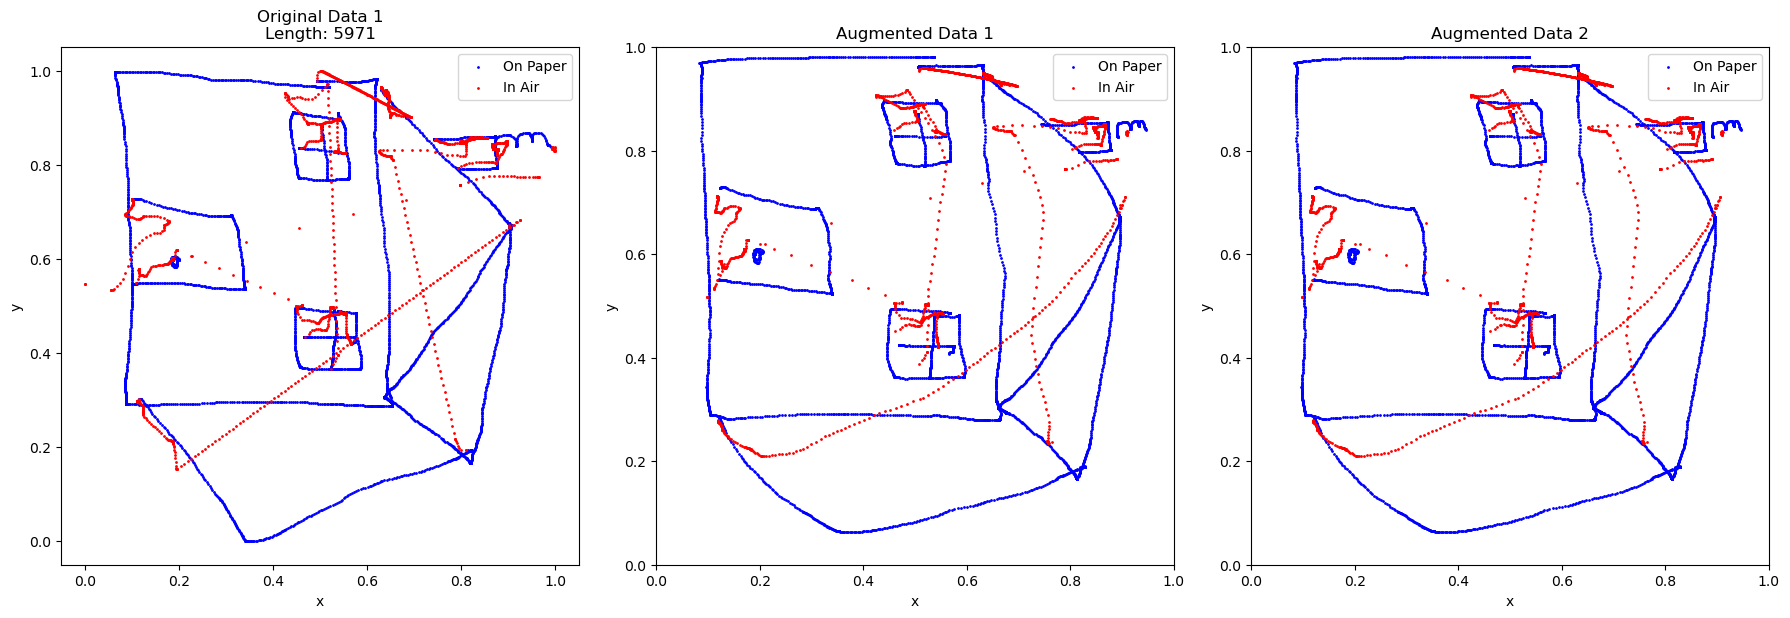

Epoch 41/100: 100%|██████████| 12/12 [00:00<00:00, 22.13batch/s, Generator Loss=0.000714, Reconstruction Loss=0.000351, KL Loss=3.63]


Epoch 41: Generator Loss = 0.000678, Reconstruction Loss = 0.000317, KL Divergence Loss = 3.604675
NRMSE = 0.329450


Epoch 42/100: 100%|██████████| 12/12 [00:00<00:00, 40.77batch/s, Generator Loss=0.000682, Reconstruction Loss=0.000325, KL Loss=3.57]


Epoch 42: Generator Loss = 0.000683, Reconstruction Loss = 0.000323, KL Divergence Loss = 3.597328
NRMSE = 0.329255


Epoch 43/100: 100%|██████████| 12/12 [00:00<00:00, 38.95batch/s, Generator Loss=0.00065, Reconstruction Loss=0.000283, KL Loss=3.66] 


Epoch 43: Generator Loss = 0.000659, Reconstruction Loss = 0.000300, KL Divergence Loss = 3.592993
NRMSE = 0.329210


Epoch 44/100: 100%|██████████| 12/12 [00:00<00:00, 13.03batch/s, Generator Loss=0.000694, Reconstruction Loss=0.000334, KL Loss=3.59]


Epoch 44: Generator Loss = 0.000653, Reconstruction Loss = 0.000294, KL Divergence Loss = 3.588428
NRMSE = 0.330314


Epoch 45/100: 100%|██████████| 12/12 [00:01<00:00,  9.30batch/s, Generator Loss=0.000691, Reconstruction Loss=0.000339, KL Loss=3.51]


Epoch 45: Generator Loss = 0.000666, Reconstruction Loss = 0.000308, KL Divergence Loss = 3.580083
NRMSE = 0.331095


Epoch 46/100: 100%|██████████| 12/12 [00:00<00:00, 16.66batch/s, Generator Loss=0.000641, Reconstruction Loss=0.000287, KL Loss=3.54]


Epoch 46: Generator Loss = 0.000721, Reconstruction Loss = 0.000364, KL Divergence Loss = 3.573720
NRMSE = 0.330104


Epoch 47/100: 100%|██████████| 12/12 [00:00<00:00, 40.80batch/s, Generator Loss=0.000704, Reconstruction Loss=0.000349, KL Loss=3.55]


Epoch 47: Generator Loss = 0.000692, Reconstruction Loss = 0.000337, KL Divergence Loss = 3.558534
NRMSE = 0.330094


Epoch 48/100: 100%|██████████| 12/12 [00:00<00:00, 42.96batch/s, Generator Loss=0.000711, Reconstruction Loss=0.000349, KL Loss=3.62]


Epoch 48: Generator Loss = 0.000661, Reconstruction Loss = 0.000306, KL Divergence Loss = 3.553696
NRMSE = 0.330907


Epoch 49/100: 100%|██████████| 12/12 [00:00<00:00, 43.46batch/s, Generator Loss=0.000694, Reconstruction Loss=0.000345, KL Loss=3.48]


Epoch 49: Generator Loss = 0.000676, Reconstruction Loss = 0.000322, KL Divergence Loss = 3.539310
NRMSE = 0.329111


Epoch 50/100: 100%|██████████| 12/12 [00:00<00:00, 19.28batch/s, Generator Loss=0.000629, Reconstruction Loss=0.000279, KL Loss=3.5] 


Epoch 50: Generator Loss = 0.000642, Reconstruction Loss = 0.000289, KL Divergence Loss = 3.532658
NRMSE = 0.330326


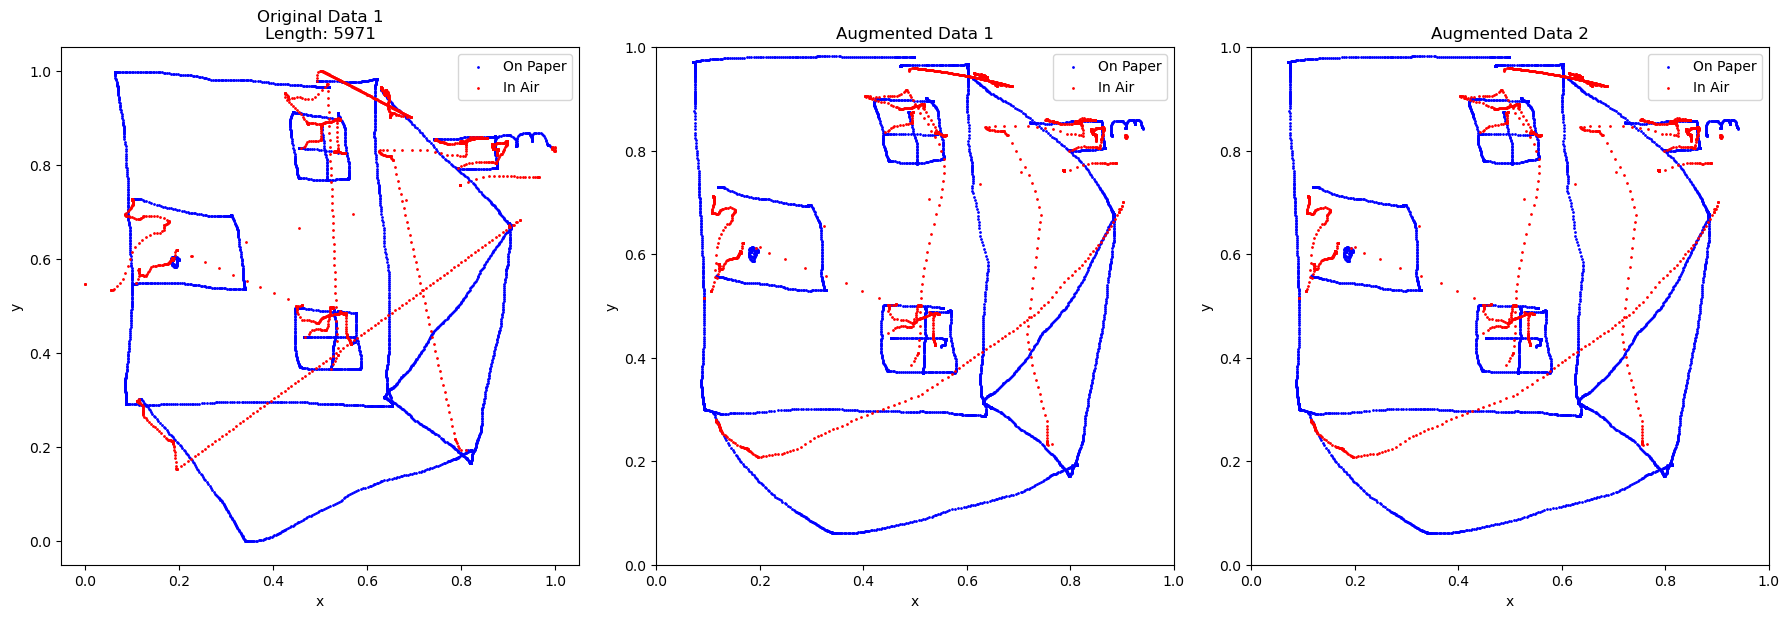

Epoch 51/100: 100%|██████████| 12/12 [00:00<00:00, 16.73batch/s, Generator Loss=0.000637, Reconstruction Loss=0.000278, KL Loss=3.59]


Epoch 51: Generator Loss = 0.000660, Reconstruction Loss = 0.000307, KL Divergence Loss = 3.528627
NRMSE = 0.329922


Epoch 52/100: 100%|██████████| 12/12 [00:00<00:00, 43.07batch/s, Generator Loss=0.000617, Reconstruction Loss=0.000262, KL Loss=3.55]


Epoch 52: Generator Loss = 0.000644, Reconstruction Loss = 0.000292, KL Divergence Loss = 3.520724
NRMSE = 0.328456


Epoch 53/100: 100%|██████████| 12/12 [00:00<00:00, 43.10batch/s, Generator Loss=0.000602, Reconstruction Loss=0.000252, KL Loss=3.51]


Epoch 53: Generator Loss = 0.000620, Reconstruction Loss = 0.000269, KL Divergence Loss = 3.512735
NRMSE = 0.328374


Epoch 54/100: 100%|██████████| 12/12 [00:00<00:00, 42.48batch/s, Generator Loss=0.000582, Reconstruction Loss=0.000226, KL Loss=3.57]


Epoch 54: Generator Loss = 0.000611, Reconstruction Loss = 0.000259, KL Divergence Loss = 3.511484
NRMSE = 0.329976


Epoch 55/100: 100%|██████████| 12/12 [00:00<00:00, 23.09batch/s, Generator Loss=0.000607, Reconstruction Loss=0.000255, KL Loss=3.52]


Epoch 55: Generator Loss = 0.000618, Reconstruction Loss = 0.000268, KL Divergence Loss = 3.504679
NRMSE = 0.330766


Epoch 56/100: 100%|██████████| 12/12 [00:00<00:00, 39.45batch/s, Generator Loss=0.000648, Reconstruction Loss=0.000302, KL Loss=3.46]


Epoch 56: Generator Loss = 0.000647, Reconstruction Loss = 0.000297, KL Divergence Loss = 3.496876
NRMSE = 0.329951


Epoch 57/100: 100%|██████████| 12/12 [00:00<00:00, 42.42batch/s, Generator Loss=0.000603, Reconstruction Loss=0.000254, KL Loss=3.49]


Epoch 57: Generator Loss = 0.000633, Reconstruction Loss = 0.000284, KL Divergence Loss = 3.492247
NRMSE = 0.329300


Epoch 58/100: 100%|██████████| 12/12 [00:00<00:00, 33.84batch/s, Generator Loss=0.000626, Reconstruction Loss=0.000285, KL Loss=3.41]


Epoch 58: Generator Loss = 0.000622, Reconstruction Loss = 0.000274, KL Divergence Loss = 3.480898
NRMSE = 0.330200


Epoch 59/100: 100%|██████████| 12/12 [00:00<00:00, 37.73batch/s, Generator Loss=0.000655, Reconstruction Loss=0.000314, KL Loss=3.41]


Epoch 59: Generator Loss = 0.000616, Reconstruction Loss = 0.000269, KL Divergence Loss = 3.475001
NRMSE = 0.329121


Epoch 60/100: 100%|██████████| 12/12 [00:00<00:00, 15.67batch/s, Generator Loss=0.000571, Reconstruction Loss=0.00023, KL Loss=3.41] 


Epoch 60: Generator Loss = 0.000614, Reconstruction Loss = 0.000267, KL Divergence Loss = 3.470598
NRMSE = 0.328604


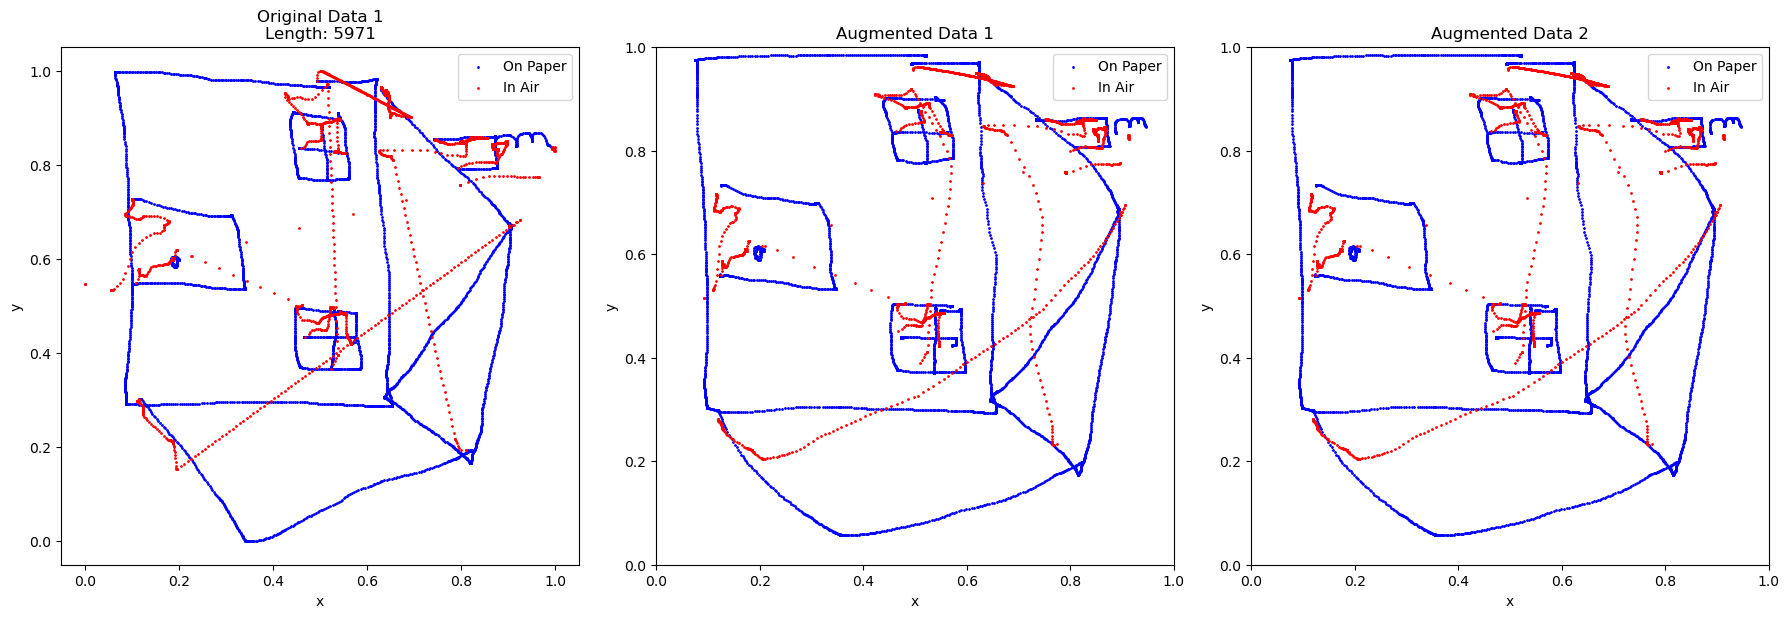

Epoch 61/100: 100%|██████████| 12/12 [00:00<00:00, 41.73batch/s, Generator Loss=0.000615, Reconstruction Loss=0.000281, KL Loss=3.34]


Epoch 61: Generator Loss = 0.000614, Reconstruction Loss = 0.000268, KL Divergence Loss = 3.457426
NRMSE = 0.329083


Epoch 62/100: 100%|██████████| 12/12 [00:00<00:00, 41.01batch/s, Generator Loss=0.000666, Reconstruction Loss=0.000318, KL Loss=3.48]


Epoch 62: Generator Loss = 0.000625, Reconstruction Loss = 0.000279, KL Divergence Loss = 3.454162
NRMSE = 0.330798


Epoch 63/100: 100%|██████████| 12/12 [00:00<00:00, 34.49batch/s, Generator Loss=0.000614, Reconstruction Loss=0.000266, KL Loss=3.48]


Epoch 63: Generator Loss = 0.000614, Reconstruction Loss = 0.000269, KL Divergence Loss = 3.450389
NRMSE = 0.329755


Epoch 64/100: 100%|██████████| 12/12 [00:00<00:00, 13.88batch/s, Generator Loss=0.000594, Reconstruction Loss=0.000248, KL Loss=3.45]


Epoch 64: Generator Loss = 0.000600, Reconstruction Loss = 0.000255, KL Divergence Loss = 3.444583
NRMSE = 0.330175


Epoch 65/100: 100%|██████████| 12/12 [00:00<00:00, 32.54batch/s, Generator Loss=0.000563, Reconstruction Loss=0.000221, KL Loss=3.42]


Epoch 65: Generator Loss = 0.000596, Reconstruction Loss = 0.000252, KL Divergence Loss = 3.441484
NRMSE = 0.329873


Epoch 66/100: 100%|██████████| 12/12 [00:00<00:00, 25.23batch/s, Generator Loss=0.000589, Reconstruction Loss=0.000247, KL Loss=3.42]


Epoch 66: Generator Loss = 0.000601, Reconstruction Loss = 0.000257, KL Divergence Loss = 3.434351
NRMSE = 0.329820


Epoch 67/100: 100%|██████████| 12/12 [00:00<00:00, 34.85batch/s, Generator Loss=0.000616, Reconstruction Loss=0.00028, KL Loss=3.36] 


Epoch 67: Generator Loss = 0.000613, Reconstruction Loss = 0.000270, KL Divergence Loss = 3.427572
NRMSE = 0.329340


Epoch 68/100: 100%|██████████| 12/12 [00:00<00:00, 40.66batch/s, Generator Loss=0.000564, Reconstruction Loss=0.000218, KL Loss=3.46]


Epoch 68: Generator Loss = 0.000575, Reconstruction Loss = 0.000233, KL Divergence Loss = 3.423020
NRMSE = 0.330448


Epoch 69/100: 100%|██████████| 12/12 [00:00<00:00, 13.15batch/s, Generator Loss=0.000588, Reconstruction Loss=0.000253, KL Loss=3.36]


Epoch 69: Generator Loss = 0.000579, Reconstruction Loss = 0.000237, KL Divergence Loss = 3.416470
NRMSE = 0.328925


Epoch 70/100: 100%|██████████| 12/12 [00:00<00:00, 29.80batch/s, Generator Loss=0.000591, Reconstruction Loss=0.000251, KL Loss=3.4] 


Epoch 70: Generator Loss = 0.000584, Reconstruction Loss = 0.000243, KL Divergence Loss = 3.413302
NRMSE = 0.330091


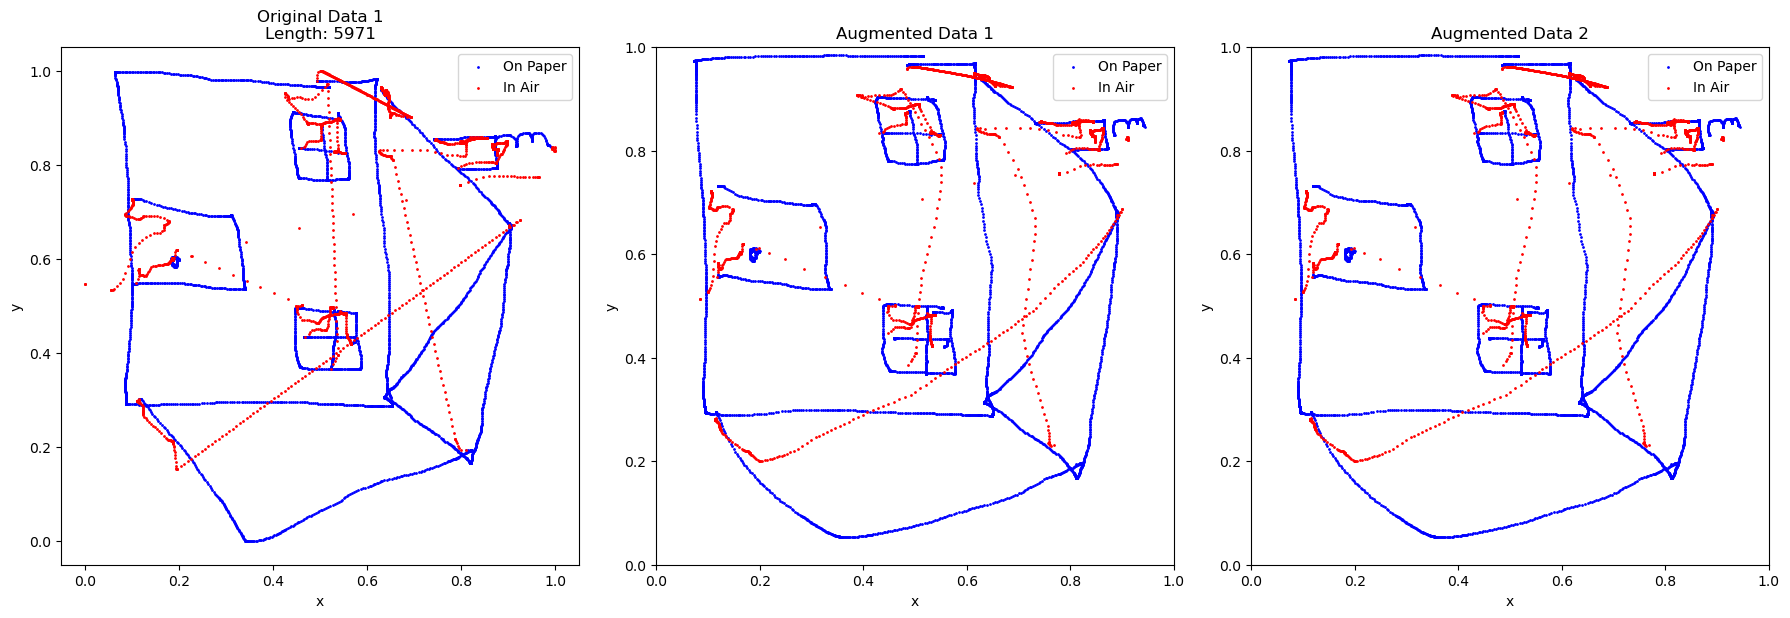

Epoch 71/100: 100%|██████████| 12/12 [00:00<00:00, 43.61batch/s, Generator Loss=0.00061, Reconstruction Loss=0.000274, KL Loss=3.36] 


Epoch 71: Generator Loss = 0.000573, Reconstruction Loss = 0.000233, KL Divergence Loss = 3.405784
NRMSE = 0.330874


Epoch 72/100: 100%|██████████| 12/12 [00:00<00:00, 44.03batch/s, Generator Loss=0.000658, Reconstruction Loss=0.000313, KL Loss=3.45]


Epoch 72: Generator Loss = 0.000634, Reconstruction Loss = 0.000294, KL Divergence Loss = 3.399315
NRMSE = 0.329365


Epoch 73/100: 100%|██████████| 12/12 [00:00<00:00, 40.65batch/s, Generator Loss=0.000572, Reconstruction Loss=0.00024, KL Loss=3.32] 


Epoch 73: Generator Loss = 0.000622, Reconstruction Loss = 0.000284, KL Divergence Loss = 3.383517
NRMSE = 0.330425


Epoch 74/100: 100%|██████████| 12/12 [00:00<00:00, 22.40batch/s, Generator Loss=0.000637, Reconstruction Loss=0.000297, KL Loss=3.4] 


Epoch 74: Generator Loss = 0.000606, Reconstruction Loss = 0.000269, KL Divergence Loss = 3.375285
NRMSE = 0.330273


Epoch 75/100: 100%|██████████| 12/12 [00:00<00:00, 16.63batch/s, Generator Loss=0.000615, Reconstruction Loss=0.000284, KL Loss=3.31]


Epoch 75: Generator Loss = 0.000596, Reconstruction Loss = 0.000260, KL Divergence Loss = 3.365903
NRMSE = 0.331502


Epoch 76/100: 100%|██████████| 12/12 [00:00<00:00, 16.70batch/s, Generator Loss=0.000618, Reconstruction Loss=0.000285, KL Loss=3.33]


Epoch 76: Generator Loss = 0.000633, Reconstruction Loss = 0.000298, KL Divergence Loss = 3.357035
NRMSE = 0.329232


Epoch 77/100: 100%|██████████| 12/12 [00:00<00:00, 40.11batch/s, Generator Loss=0.000563, Reconstruction Loss=0.00023, KL Loss=3.34] 


Epoch 77: Generator Loss = 0.000576, Reconstruction Loss = 0.000242, KL Divergence Loss = 3.342976
NRMSE = 0.330743


Epoch 78/100: 100%|██████████| 12/12 [00:00<00:00, 14.33batch/s, Generator Loss=0.000588, Reconstruction Loss=0.000262, KL Loss=3.26]


Epoch 78: Generator Loss = 0.000575, Reconstruction Loss = 0.000242, KL Divergence Loss = 3.333927
NRMSE = 0.331264


Epoch 79/100: 100%|██████████| 12/12 [00:00<00:00, 30.91batch/s, Generator Loss=0.000583, Reconstruction Loss=0.000248, KL Loss=3.35]


Epoch 79: Generator Loss = 0.000574, Reconstruction Loss = 0.000241, KL Divergence Loss = 3.334496
NRMSE = 0.330927


Epoch 80/100: 100%|██████████| 12/12 [00:00<00:00, 36.05batch/s, Generator Loss=0.000543, Reconstruction Loss=0.000211, KL Loss=3.32]


Epoch 80: Generator Loss = 0.000560, Reconstruction Loss = 0.000226, KL Divergence Loss = 3.331135
NRMSE = 0.330467


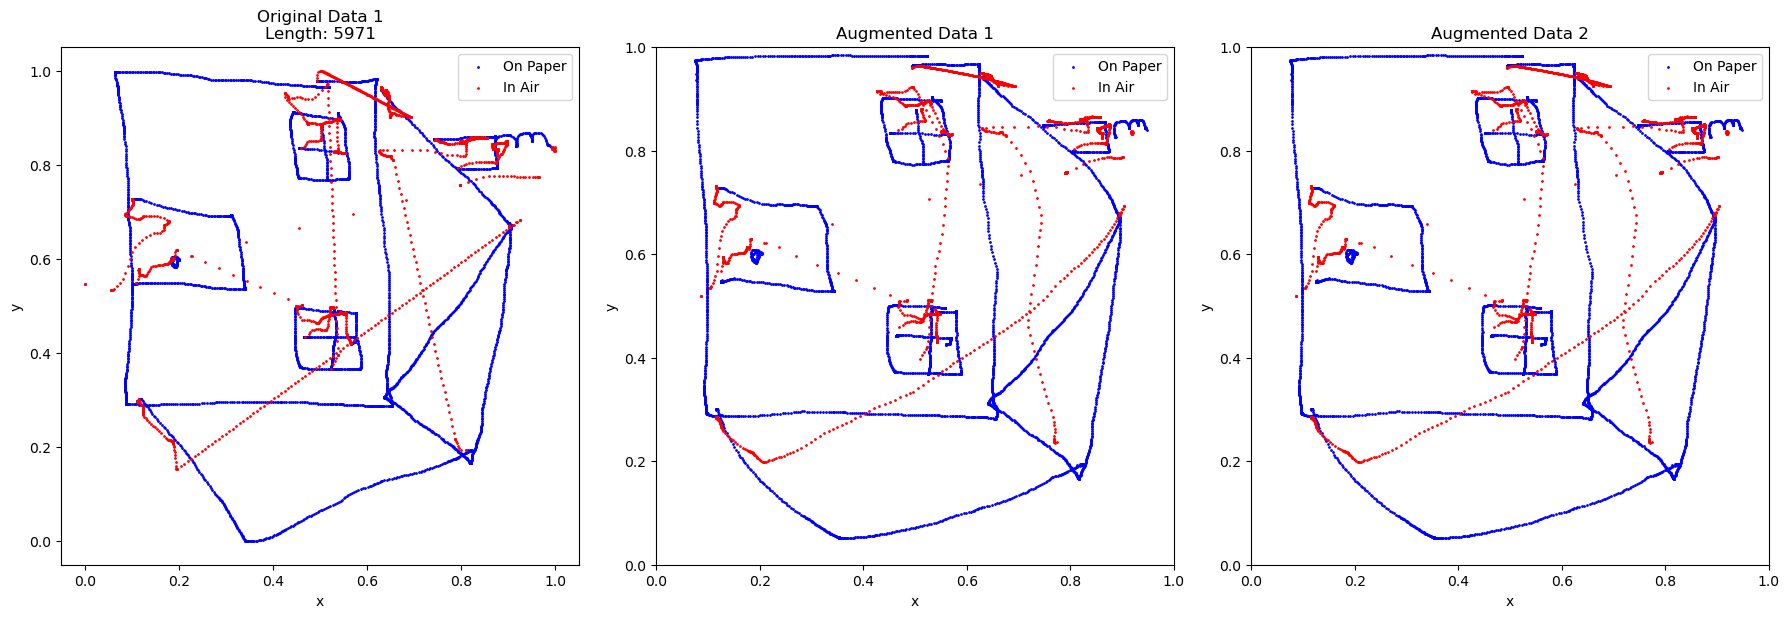

Epoch 81/100: 100%|██████████| 12/12 [00:00<00:00, 40.58batch/s, Generator Loss=0.000608, Reconstruction Loss=0.000276, KL Loss=3.32]


Epoch 81: Generator Loss = 0.000556, Reconstruction Loss = 0.000223, KL Divergence Loss = 3.328535
NRMSE = 0.330701


Epoch 82/100: 100%|██████████| 12/12 [00:00<00:00, 26.79batch/s, Generator Loss=0.000582, Reconstruction Loss=0.000246, KL Loss=3.36]


Epoch 82: Generator Loss = 0.000556, Reconstruction Loss = 0.000224, KL Divergence Loss = 3.325485
NRMSE = 0.330226


Epoch 83/100: 100%|██████████| 12/12 [00:00<00:00, 30.88batch/s, Generator Loss=0.00055, Reconstruction Loss=0.000221, KL Loss=3.29] 


Epoch 83: Generator Loss = 0.000574, Reconstruction Loss = 0.000243, KL Divergence Loss = 3.317061
NRMSE = 0.331230


Epoch 84/100: 100%|██████████| 12/12 [00:00<00:00, 42.17batch/s, Generator Loss=0.000512, Reconstruction Loss=0.000186, KL Loss=3.27]


Epoch 84: Generator Loss = 0.000553, Reconstruction Loss = 0.000222, KL Divergence Loss = 3.306010
NRMSE = 0.331261


Epoch 85/100: 100%|██████████| 12/12 [00:00<00:00, 15.51batch/s, Generator Loss=0.000575, Reconstruction Loss=0.000244, KL Loss=3.31]


Epoch 85: Generator Loss = 0.000567, Reconstruction Loss = 0.000236, KL Divergence Loss = 3.303720
NRMSE = 0.328143


Epoch 86/100: 100%|██████████| 12/12 [00:00<00:00, 27.81batch/s, Generator Loss=0.000511, Reconstruction Loss=0.000174, KL Loss=3.37]


Epoch 86: Generator Loss = 0.000548, Reconstruction Loss = 0.000218, KL Divergence Loss = 3.303557
NRMSE = 0.331127


Epoch 87/100: 100%|██████████| 12/12 [00:00<00:00, 40.18batch/s, Generator Loss=0.00055, Reconstruction Loss=0.000219, KL Loss=3.31] 


Epoch 87: Generator Loss = 0.000546, Reconstruction Loss = 0.000216, KL Divergence Loss = 3.296804
NRMSE = 0.329526


Epoch 88/100: 100%|██████████| 12/12 [00:00<00:00, 40.17batch/s, Generator Loss=0.000538, Reconstruction Loss=0.000204, KL Loss=3.33]


Epoch 88: Generator Loss = 0.000536, Reconstruction Loss = 0.000207, KL Divergence Loss = 3.298437
NRMSE = 0.331113


Epoch 89/100: 100%|██████████| 12/12 [00:00<00:00, 17.11batch/s, Generator Loss=0.000551, Reconstruction Loss=0.000221, KL Loss=3.31]


Epoch 89: Generator Loss = 0.000541, Reconstruction Loss = 0.000212, KL Divergence Loss = 3.291343
NRMSE = 0.331260


Epoch 90/100: 100%|██████████| 12/12 [00:00<00:00, 39.45batch/s, Generator Loss=0.000553, Reconstruction Loss=0.000229, KL Loss=3.24]


Epoch 90: Generator Loss = 0.000553, Reconstruction Loss = 0.000225, KL Divergence Loss = 3.282230
NRMSE = 0.331891


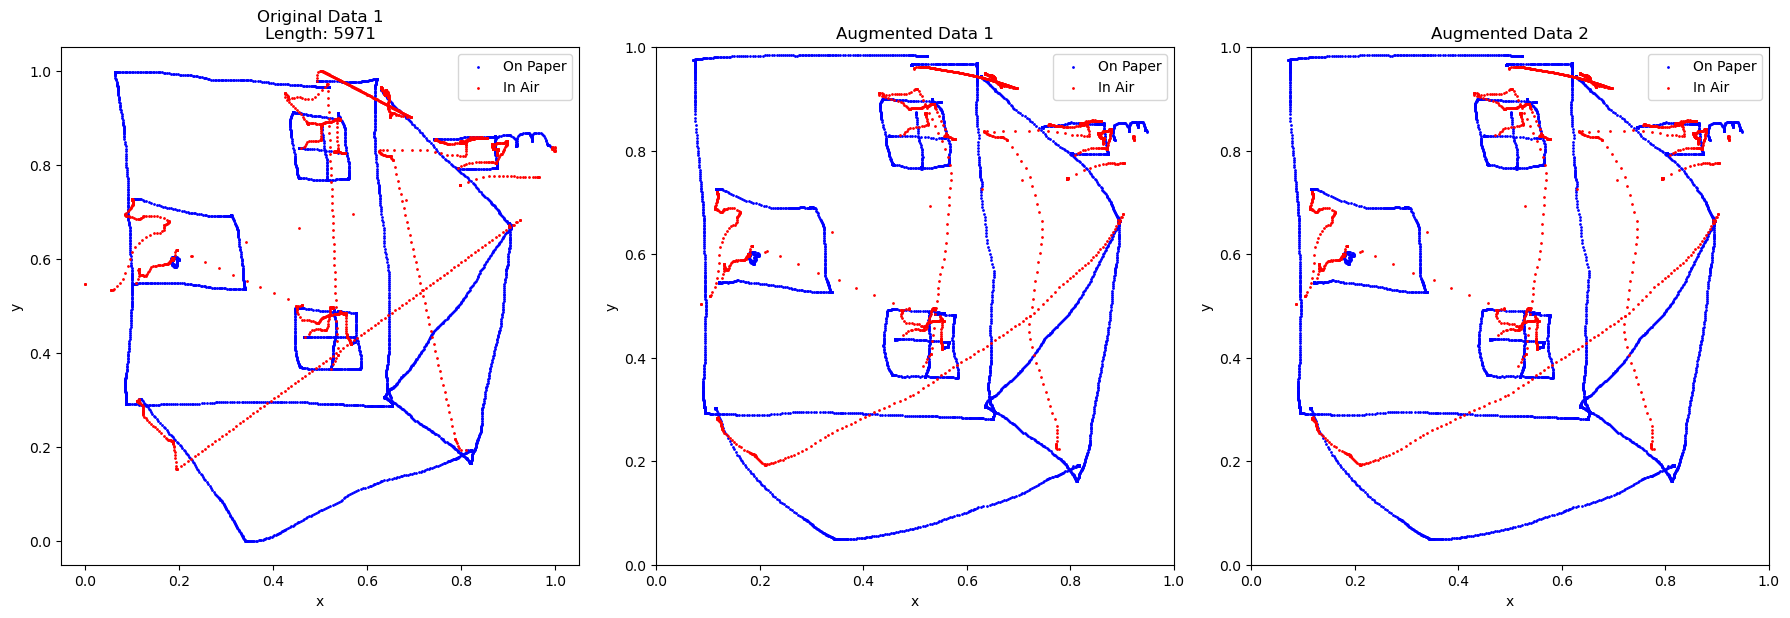

Epoch 91/100: 100%|██████████| 12/12 [00:00<00:00, 41.48batch/s, Generator Loss=0.000528, Reconstruction Loss=0.000196, KL Loss=3.33]


Epoch 91: Generator Loss = 0.000545, Reconstruction Loss = 0.000217, KL Divergence Loss = 3.278755
NRMSE = 0.331036


Epoch 92/100: 100%|██████████| 12/12 [00:00<00:00, 40.89batch/s, Generator Loss=0.000555, Reconstruction Loss=0.000229, KL Loss=3.26]


Epoch 92: Generator Loss = 0.000549, Reconstruction Loss = 0.000222, KL Divergence Loss = 3.272880
NRMSE = 0.329594


Epoch 93/100: 100%|██████████| 12/12 [00:00<00:00, 43.21batch/s, Generator Loss=0.00056, Reconstruction Loss=0.000238, KL Loss=3.21] 


Epoch 93: Generator Loss = 0.000569, Reconstruction Loss = 0.000243, KL Divergence Loss = 3.266155
NRMSE = 0.331357


Epoch 94/100: 100%|██████████| 12/12 [00:00<00:00, 20.79batch/s, Generator Loss=0.000547, Reconstruction Loss=0.000218, KL Loss=3.3] 


Epoch 94: Generator Loss = 0.000556, Reconstruction Loss = 0.000231, KL Divergence Loss = 3.258667
NRMSE = 0.332160


Epoch 95/100: 100%|██████████| 12/12 [00:00<00:00, 42.80batch/s, Generator Loss=0.000513, Reconstruction Loss=0.000189, KL Loss=3.25]


Epoch 95: Generator Loss = 0.000529, Reconstruction Loss = 0.000204, KL Divergence Loss = 3.251349
NRMSE = 0.328824


Epoch 96/100: 100%|██████████| 12/12 [00:00<00:00, 23.81batch/s, Generator Loss=0.000569, Reconstruction Loss=0.000246, KL Loss=3.24]


Epoch 96: Generator Loss = 0.000539, Reconstruction Loss = 0.000214, KL Divergence Loss = 3.247400
NRMSE = 0.332047


Epoch 97/100: 100%|██████████| 12/12 [00:00<00:00, 43.17batch/s, Generator Loss=0.000528, Reconstruction Loss=0.000204, KL Loss=3.24]


Epoch 97: Generator Loss = 0.000538, Reconstruction Loss = 0.000213, KL Divergence Loss = 3.243608
NRMSE = 0.330343


Epoch 98/100: 100%|██████████| 12/12 [00:00<00:00, 33.22batch/s, Generator Loss=0.000504, Reconstruction Loss=0.000175, KL Loss=3.29]


Epoch 98: Generator Loss = 0.000538, Reconstruction Loss = 0.000214, KL Divergence Loss = 3.242090
NRMSE = 0.329332


Epoch 99/100: 100%|██████████| 12/12 [00:00<00:00, 28.22batch/s, Generator Loss=0.000484, Reconstruction Loss=0.000163, KL Loss=3.21]


Epoch 99: Generator Loss = 0.000521, Reconstruction Loss = 0.000198, KL Divergence Loss = 3.234477
NRMSE = 0.329975


Epoch 100/100: 100%|██████████| 12/12 [00:00<00:00, 43.37batch/s, Generator Loss=0.000535, Reconstruction Loss=0.000215, KL Loss=3.2] 


Epoch 100: Generator Loss = 0.000530, Reconstruction Loss = 0.000207, KL Divergence Loss = 3.229476
NRMSE = 0.331154


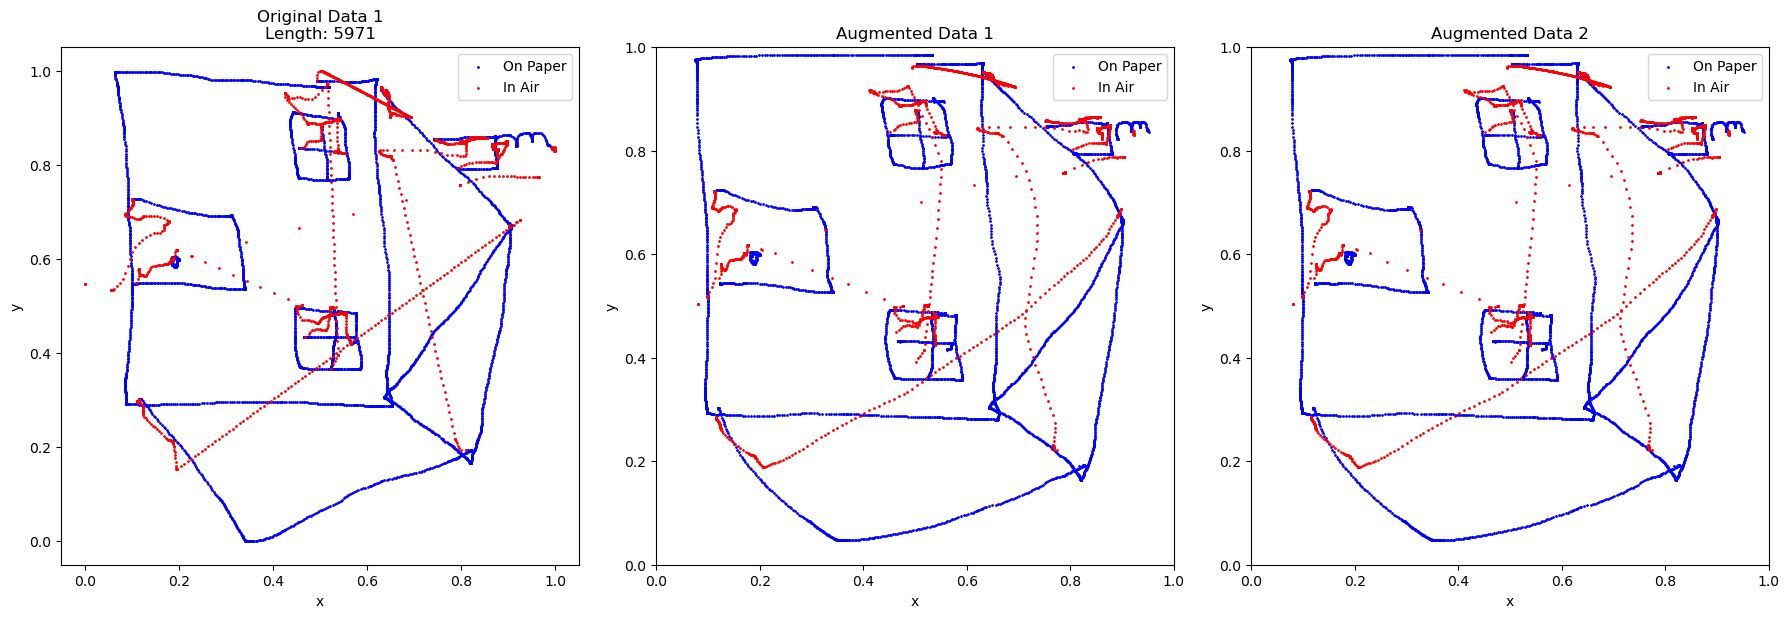

Final NRMSE: 0.331154
Training completed.
VAE model saved.


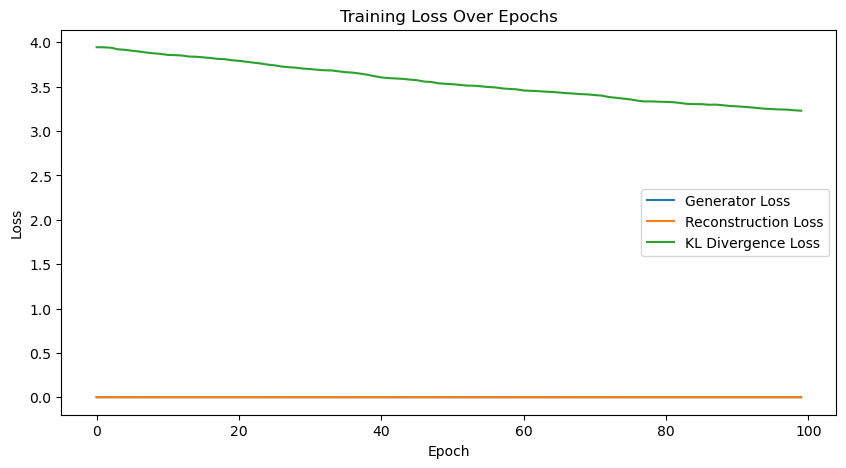

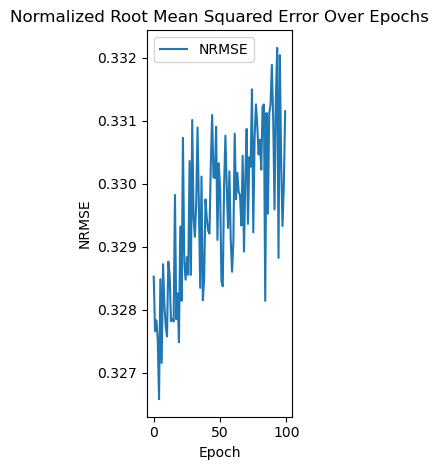

In [12]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss + 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 100
lstm_interval = 10
epochs = 100
visual_per_num_epoch = 10
num_augmented_files = 2

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                # Use LSTM discriminator after vae_epochs and every lstm_interval
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train the LSTM discriminator every lstm_interval epochs after vae_epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)  # Reshape for LSTM input
            generated_data = tf.expand_dims(augmented_data, axis=0)

            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')

    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")

    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + len(processed_data), figsize=(6*(num_augmented_files + len(processed_data)), 6))
        
        for i, original_data in enumerate(processed_data):
            original_on_paper = original_data[original_data[:, 3] == 1]
            original_in_air = original_data[original_data[:, 3] == 0]
            axs[i].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].set_xlabel('x')
            axs[i].set_ylabel('y')
            axs[i].set_aspect('equal')
            axs[i].legend()

        # Set consistent axis limits for square aspect ratio
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            axs[i+len(processed_data)].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i+len(processed_data)].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i+len(processed_data)].set_title(f'Augmented Data {i+1}')
            axs[i+len(processed_data)].set_xlabel('x')
            axs[i+len(processed_data)].set_ylabel('y')
            axs[i+len(processed_data)].set_aspect('equal')
            axs[i+len(processed_data)].set_xlim(x_min, x_max)
            axs[i+len(processed_data)].set_ylim(y_min, y_max)
            axs[i+len(processed_data)].legend()

        plt.tight_layout()
        plt.show()

# Final output of metrics
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

vae.save('pentab_saved_model.h5')
print("VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pretrained VAE model loaded.


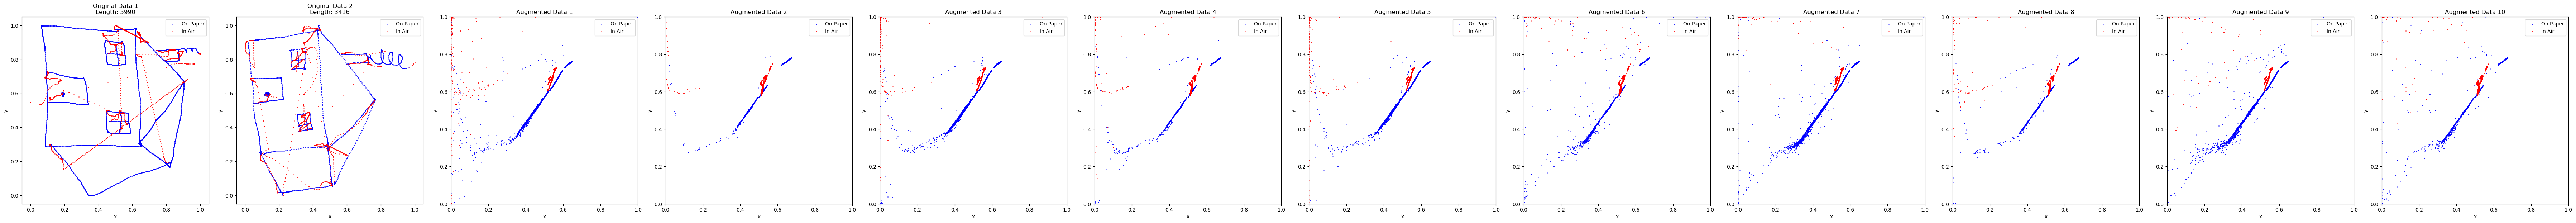

In [18]:
# Cell 9
# Load the pretrained VAE model
with custom_object_scope({'VAE': VAE}):
    vae_pretrained = load_model('pentab_saved_model.h5')
print("Pretrained VAE model loaded.")
base_latent_variability = 100.0
latent_variability_range = (0.1, 5.0)
# length_variability = 0.05
num_augmented_files = 10
# Generate augmented data using the pretrained model
augmented_datasets = generate_augmented_data(vae_pretrained, num_augmented_files, avg_data_points, processed_data, 
                                             base_latent_variability, latent_variability_range)

# Calculate actual latent variabilities and lengths used
latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
augmented_lengths = [len(data) for data in augmented_datasets]

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + len(processed_data), figsize=(6*(num_augmented_files + len(processed_data)), 6))

for i, original_data in enumerate(processed_data):
    original_on_paper = original_data[original_data[:, 3] == 1]
    original_in_air = original_data[original_data[:, 3] == 0]
    axs[i].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i].set_title(f'Original Data {i+1}\nLength: {len(original_data)}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_aspect('equal')
    axs[i].legend()

# Set consistent axis limits for square aspect ratio
x_min = min(data[:, 0].min() for data in processed_data)
x_max = max(data[:, 0].max() for data in processed_data)
y_min = min(data[:, 1].min() for data in processed_data)
y_max = max(data[:, 1].max() for data in processed_data)

for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
    augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
    axs[i+len(processed_data)].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i+len(processed_data)].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i+len(processed_data)].set_title(f'Augmented Data {i+1}')
    axs[i+len(processed_data)].set_xlabel('x')
    axs[i+len(processed_data)].set_ylabel('y')
    axs[i+len(processed_data)].set_aspect('equal')
    axs[i+len(processed_data)].set_xlim(x_min, x_max)
    axs[i+len(processed_data)].set_ylim(y_min, y_max)
    axs[i+len(processed_data)].legend()

plt.tight_layout()
plt.show()

In [19]:
# Cell 10
def download_augmented_data_as_integers(augmented_datasets, scaler, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, original_df, original_filename) in enumerate(zip(augmented_datasets, original_data_frames, original_filenames)):
        # Ensure the arrays have matching sizes by trimming the larger one
        min_rows = min(len(augmented_data), len(original_df))
        
        # Trim augmented_data if necessary
        augmented_data_trimmed = augmented_data[:min_rows, :]
        
        # Trim original_df if necessary
        original_df_trimmed = original_df.iloc[:min_rows]

        # Reconstruct the original columns and round to nearest whole number
        augmented_data_original_scale = np.column_stack((
            np.rint(scaler.inverse_transform(augmented_data_trimmed[:, :3])).astype(int),  # Round and convert to integers: x, y, timestamp
            augmented_data_trimmed[:, 3].astype(int),  # Pen status (binary, ensure it's integer 0 or 1)
            np.rint(original_df_trimmed[['pressure', 'azimuth', 'altitude']].values).astype(int)  # Round pressure, azimuth, altitude to integers
        ))

        # Construct the new filename by modifying the original filename
        base_name, ext = os.path.splitext(original_filename)
        new_filename = os.path.join(directory, f'{base_name}_augmented{ext}')
        
        # Save each augmented dataset to a .svc file
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']).to_csv(new_filename, index=False, sep=' ', header=False)
        
        # Print the full file path to indicate where it's saved
        print(f"Saved {os.path.abspath(new_filename)}")

# Call the updated function with original filenames
download_augmented_data_as_integers(augmented_datasets, scalers[0], data_frames, original_filenames)


Saved c:\Users\katod\OneDrive - Itech\NEW Backup\Kurt Files\Kurt Files All\Github\Thesis-Project\model\augmented_data\DataFrame_1_augmented
Saved c:\Users\katod\OneDrive - Itech\NEW Backup\Kurt Files\Kurt Files All\Github\Thesis-Project\model\augmented_data\DataFrame_2_augmented


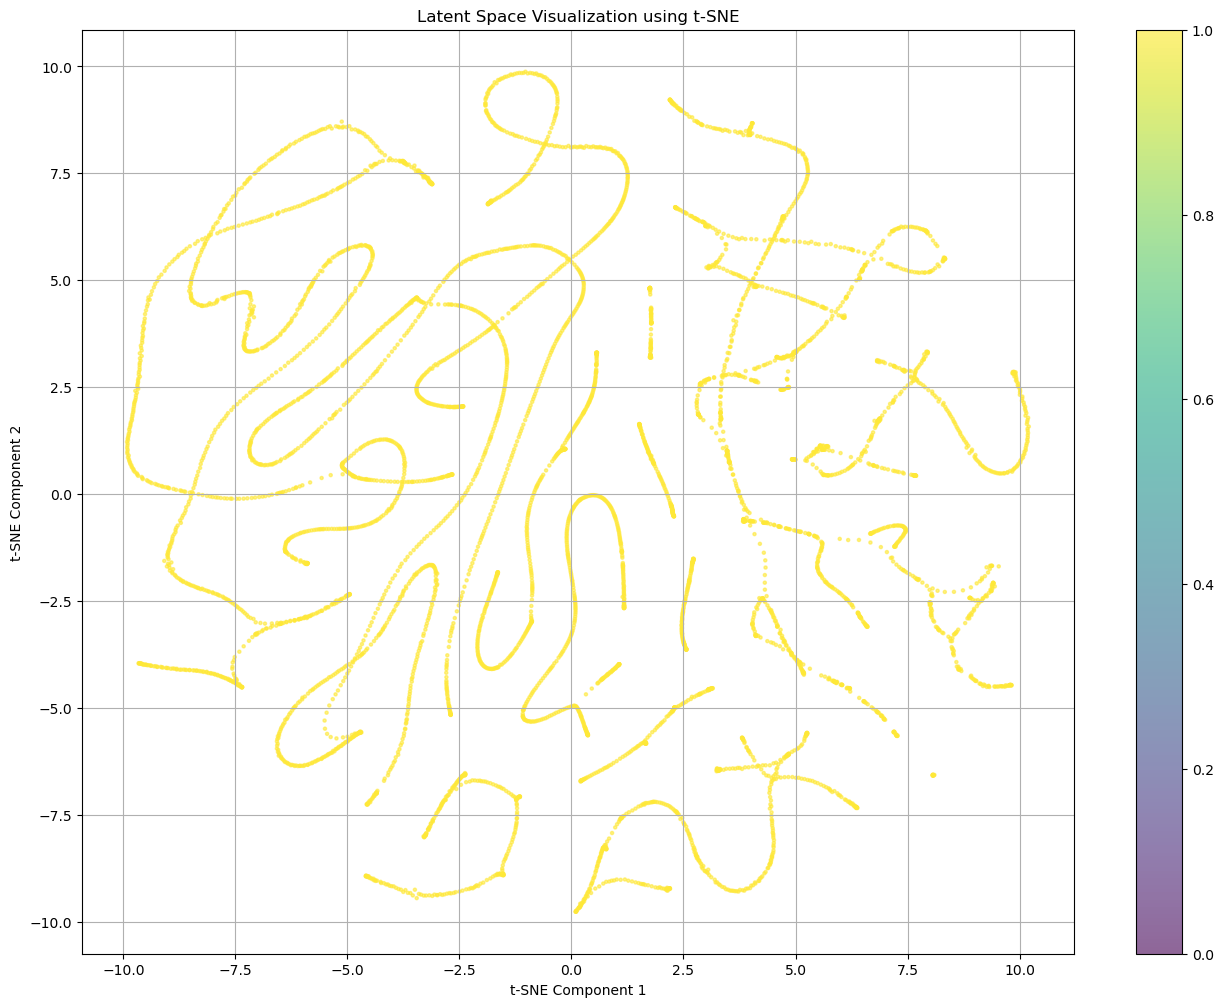

In [22]:
#Cell 11 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])